In [17]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 200
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.autolayout': True,
         'text.usetex': True,
         'text.latex.preamble': [r"\usepackage{bm}"]}
pylab.rcParams.update(params)

from colors_labels import *
import bao_utils

In [2]:
import Corrfunc
from Corrfunc.io import read_lognormal_catalog, read_fortran_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import spline, bao

In [3]:
#colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']*6
colors = ['#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255', '#332288']*6

In [4]:
plot_dir = '../plots/plots_2020-01-28'

In [5]:
def distance(pointa, pointb):
    return np.linalg.norm(np.array(pointa)-np.array(pointb))

In [6]:
def circle(x, r):
    return np.sqrt(r**2 - x**2)

In [7]:
def rand_between(mymin, mymax, n=1):
    return np.random.rand(n)*(mymax-mymin) + mymin

In [54]:
def get_nonzero_bases(r, base, n, nbases):
    
    if n==0:
        base[0] = 0
    if n==nbases-1:
        base[-1] = 0
    r_nz = []
    base_nz = []
    for i in range(len(base)):
        if base[i]==0:
            if i>0 and base[i-1]==1:
                base_nz.append(0)
                r_nz.append(r[i])
            elif i<len(base)-1 and base[i+1]==1:
                base_nz.append(0)
                r_nz.append(r[i])
        else:
            base_nz.append(base[i])
            r_nz.append(r[i])
    return np.array(r_nz), np.array(base_nz)        
    

In [86]:
def bases_panel(ax, bases, colors, rsep, rcolor, bases_ordered=None, rescale_by=None, 
                xlim=(0, 140), ylim=(0,1), labelx=False):

    bases = bases.copy()
    r = bases[:,0]
    nbases = len(bases[0])-1
    
    if bases_ordered is None:
        bases_ordered = np.arange(nbases)
    
    for i in bases_ordered:
        base = bases[:,i+1]
        if rescale_by is not None:
            base *= rescale_by[i]
               
        r_nz, base_nz = get_nonzero_bases(r, base, i, nbases)
        ax.plot(r_nz, base_nz, color=colors[i], lw=2)
        
        # plot intersection points with rsep line
        idx = (np.abs(r - rsep)).argmin()
        base_val = base[idx]
        if base_val!=0:
            ax.scatter(rsep, base_val, color=colors[i], marker='d', s=70,
                       edgecolor=rcolor, zorder=1000)
    
    ax.axvline(rsep, color=rcolor, alpha=0.6, ls='-', lw=3, zorder=0)
    ax.text(rsep-14, 0.75*ylim[1], r"$r_{nn'}$", fontsize=20)
        
    ax.axhline(0, color='grey', lw=0.8, zorder=0)
        
    if labelx:
        ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel('basis functions $f_k(r)$')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    ax.locator_params(axis='y', nbins=5)
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

In [88]:
def results_panel(ax, bases, colors, amps, r_fine, xi, bases_ordered=None, xlim=(0, 140), ylim=None):

    bases = bases.copy()
    r = bases[:,0]
    nbases = len(bases[0])-1
    
    if bases_ordered is None:
        bases_ordered = np.arange(nbases)
        
    for i in bases_ordered:
        base = bases[:,i+1]
        r_nz, base_nz = get_nonzero_bases(r, base, i, nbases)
        base_nz *= amps[i]
        ax.plot(r_nz, base_nz, color=colors[i], lw=2)
        
    ax.plot(r_fine, xi, color='k', lw=3)
        
    ax.axhline(0, color='grey', lw=0.8, zorder=0)
    
    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'$a_k \, f_k(r), \,\,\, \xi(r)$')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    #ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.locator_params(axis='y', nbins=3)
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

In [19]:
def data_panel(ax, data, zslice=(0,300), xlim=(0, 140), ylim=(0,70), gal=[97, 40]):
    
    # settings
    marker = 'o'
    size=5
    col='dimgrey'
    col_points = 'grey'
    alpha_points = 0.6
    n = 200
    circle_alpha = 0.6
    highlight_radius = 3

    # two main galaxies
    gal_main = [0, 0]
    ax.scatter(gal_main[0], gal_main[1], marker=marker, c=col_points, s=size, alpha=alpha_points, zorder=1000, lw=0)
    highlight = plt.Circle(gal_main, radius=highlight_radius, fill=None, color=col, lw=2)
    ax.add_artist(highlight)

    ax.scatter(gal[0], gal[1], marker=marker, c=col_points, s=size, alpha=alpha_points, zorder=1000, lw=0)
    highlight = plt.Circle(gal, radius=highlight_radius, fill=None, color=col, lw=2)
    ax.add_artist(highlight)

    # circles and lines
    r = distance(gal_main, gal)
    x = np.linspace(rmin-2, rmax, 30000)
    circ = circle(x, r)
    ax.plot(np.concatenate((x, [r])), np.concatenate((circ, [0])), color=col, lw=3, zorder=0, alpha=circle_alpha)
    ax.plot(x, -circ, color=col, lw=3, zorder=0, alpha=circle_alpha)
    ax.plot([gal_main[0], gal[0]], [gal_main[1], gal[1]], color=col, linestyle='-', linewidth=2)
    ax.text(0.5*(gal_main[0] + gal[0]), 0.5*(gal_main[1] + gal[1])+7, r"$r_{nn'}$", fontsize=20)

    # all points
    in_slice = np.argwhere((zslice[0] <= data[2]) & (data[2] < zslice[1]))
    xdata = data[0][in_slice]
    ydata = data[1][in_slice]
    ax.scatter(xdata, ydata, marker=marker, c=col_points, s=size, alpha=alpha_points, lw=0)

    ax.set_ylabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set(xlim=xlim, ylim=ylim, aspect=1)
    ax.set(adjustable="box")
    
    return r, col

## load lognormal data

In [11]:
realization = 1
boxsize = 750
cat_tag = f'_L{boxsize}_n2e-4_z057_patchy'
cat_fn = f'../catalogs/lognormal/cat{cat_tag}_lognormal_rlz{realization}.bin'

In [12]:
x, y, z = read_fortran_catalog(cat_fn)
data = [x, y, z]
boxsize = 750.0
nd = len(x)
print("Number of data points:",nd)

Number of data points: 85575


In [13]:
# parameters for both
rmin = 0.0
rmax = 140.0
ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)
nmubins = 1
mumax = 1.0
periodic = True
nthreads = 1
proj_type = 'generalr'
volume = boxsize**3

## spline basis

In [36]:
nprojbins_spline = 16
r_edges_spline = np.linspace(rmin, rmax, nprojbins_spline+1)

In [37]:
kwargs_spline = {'order': 3} # 3: cubic spline
projfn_spline = '../tables/cubic_spline.dat'
spline.write_bases(rmin, rmax, nprojbins_spline, projfn_spline, ncont=ncont, **kwargs_spline)

'../tables/cubic_spline.dat'

In [38]:
dd_res_spline, dd_proj_spline, _ = DDsmu(1, nthreads, r_edges_spline, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                           nprojbins=nprojbins_spline, projfn=projfn_spline)

In [39]:
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins_spline, proj_type, 
                                           projfn=projfn_spline, rbins=r_edges_spline)
numerator_spline = dd_proj_spline - rr_ana_spline
amps_ana_spline = np.linalg.solve(qq_ana_spline, numerator_spline)
xi_ana_spline = evaluate_xi(amps_ana_spline, r_fine, proj_type, projfn=projfn_spline, rbins=r_edges_spline)

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


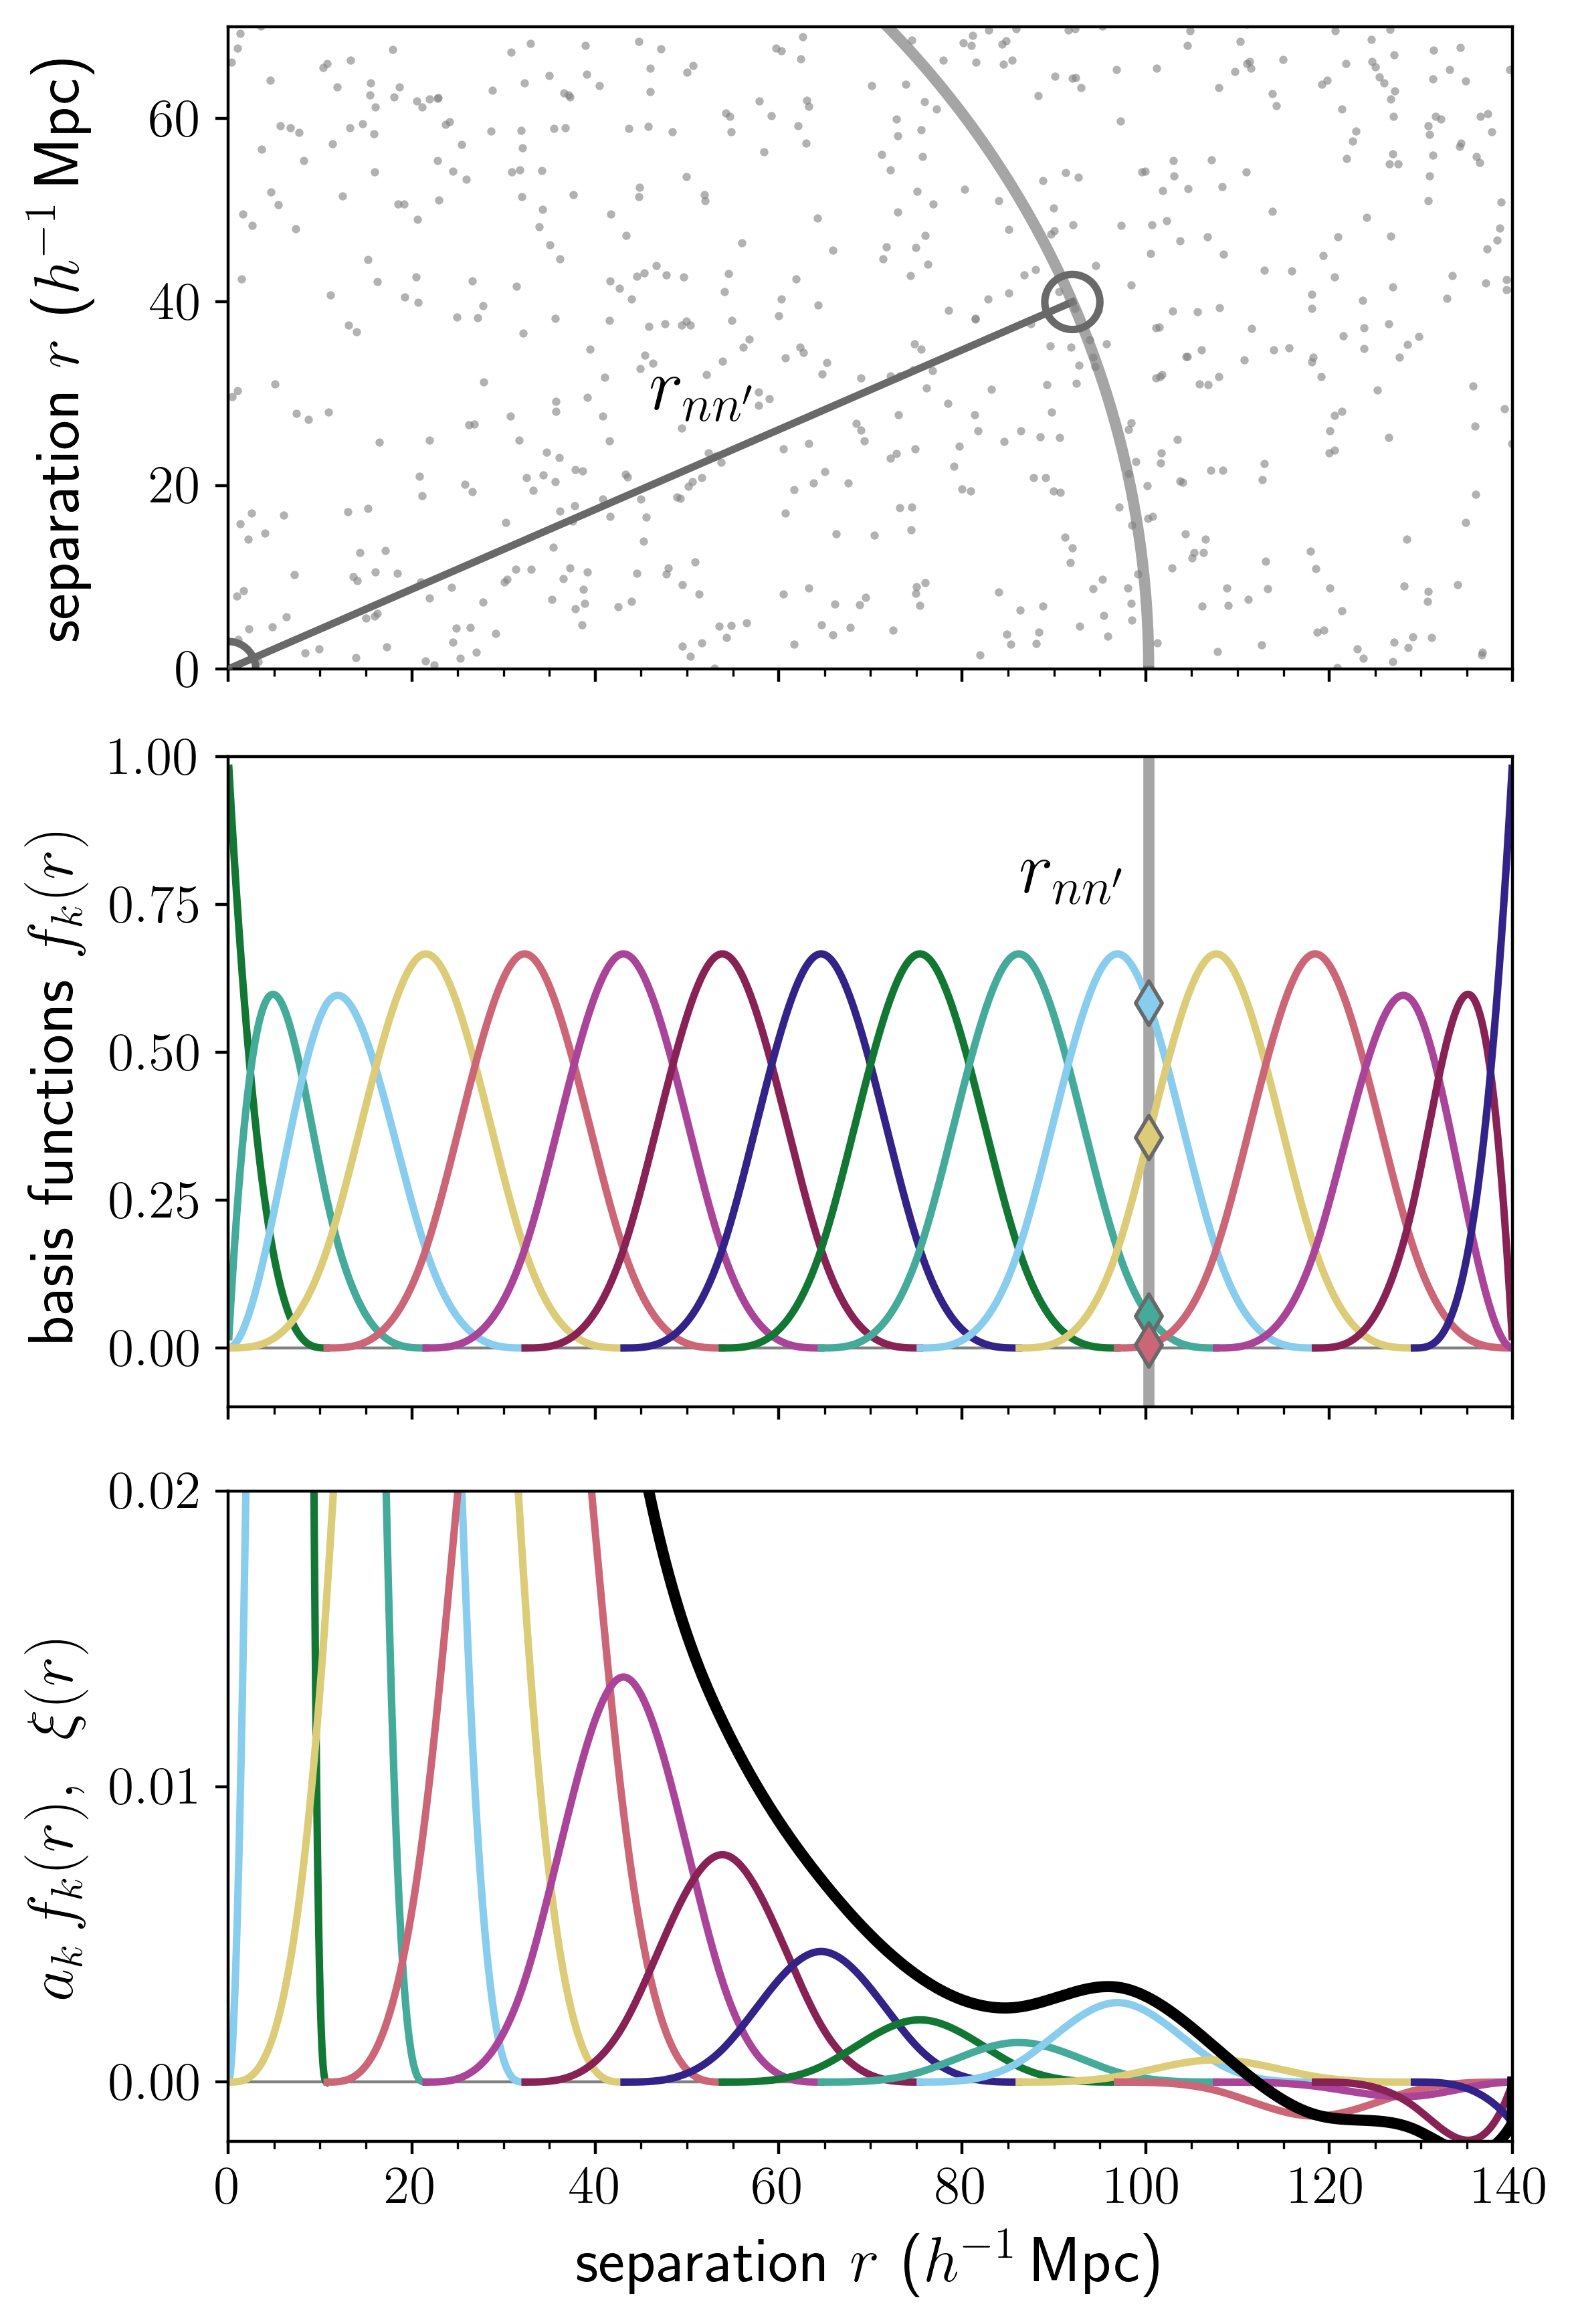

In [87]:
fig, axarr = plt.subplots(3,1, figsize=(6,8.8), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

bases_spline = np.loadtxt(projfn_spline)

rsep, rcolor = data_panel(axarr[0], data, gal=[92,40])
bases_panel(axarr[1], bases_spline, colors, rsep, rcolor, ylim=(-0.1, 1))
results_panel(axarr[2], bases_spline, colors, amps_ana_spline, r_fine, xi_ana_spline, ylim=(-0.002, 0.02))
fig.align_ylabels(axarr)

save_fn = 'schematic_spline.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


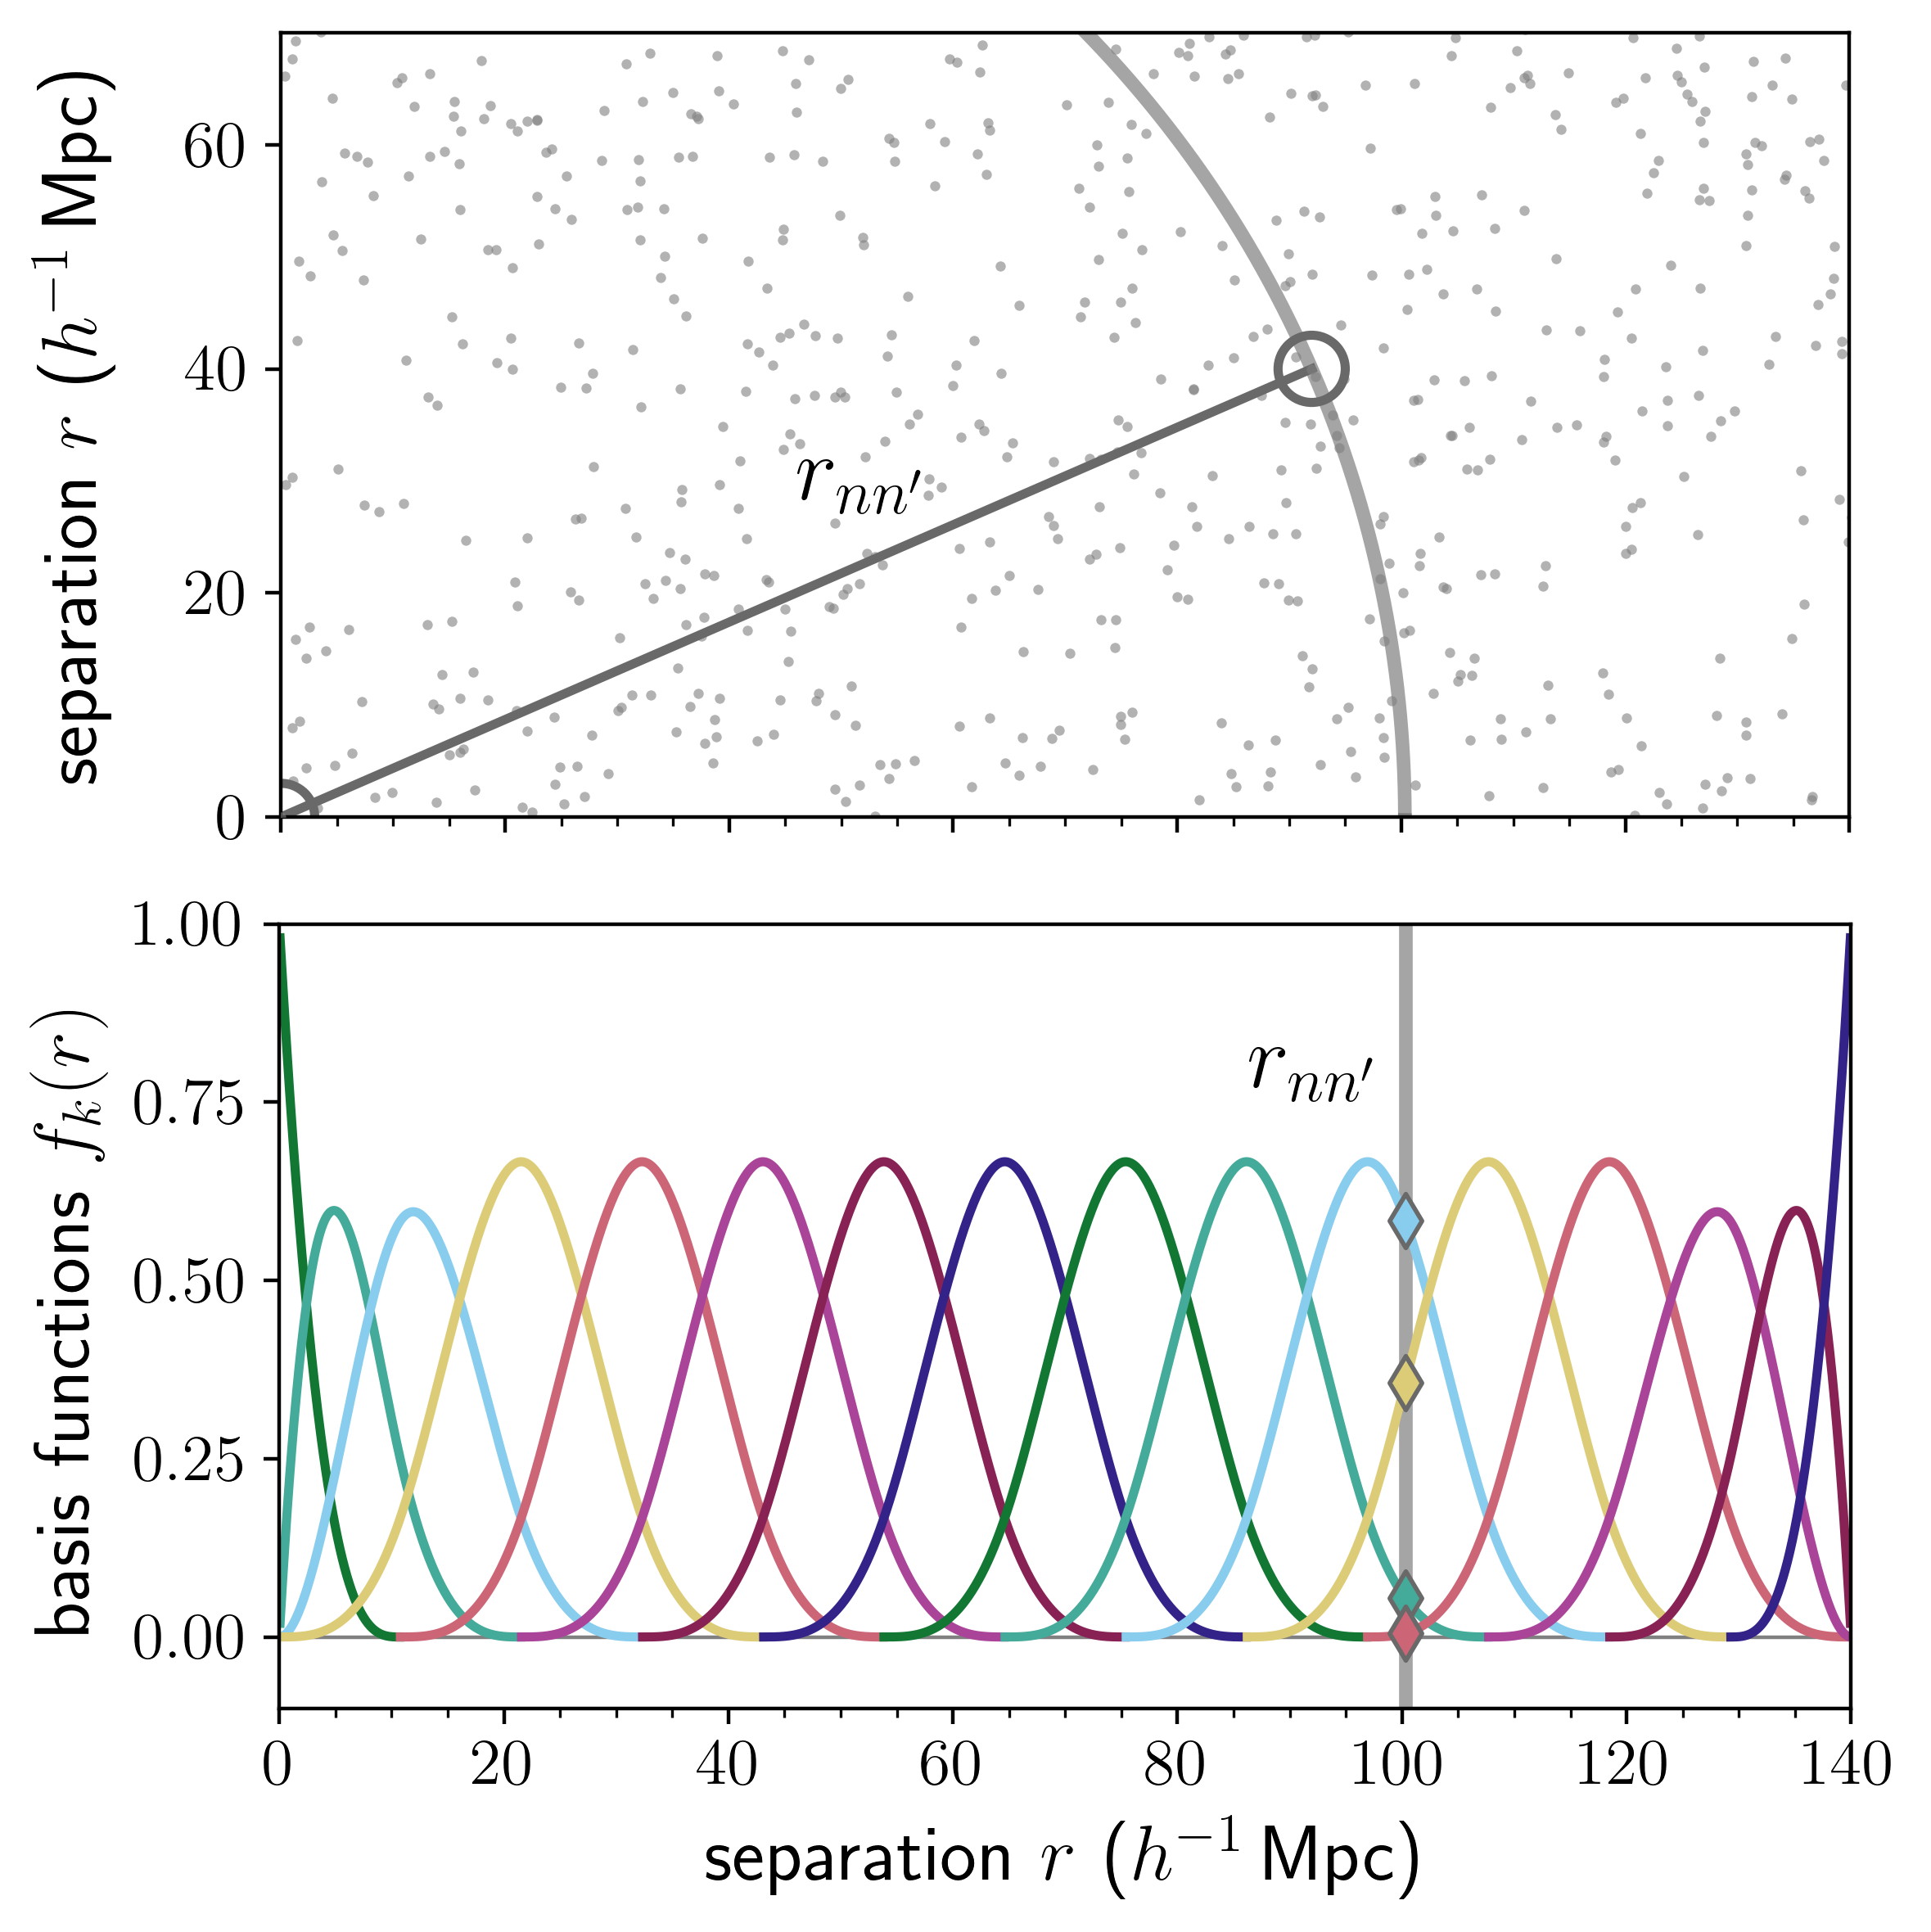

In [73]:
fig, axarr = plt.subplots(2,1, figsize=(6,2./3.*9.0), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

bases_spline = np.loadtxt(projfn_spline)

rsep, rcolor = data_panel(axarr[0], data, gal=[92,40])
bases_panel(axarr[1], bases_spline, colors, rsep, rcolor, ylim=(-0.1, 1), labelx=True)
#results_panel(axarr[2], bases_spline, colors, amps_ana_tophat, r_fine, xi_ana_tophat, ylim=(-0.002, 0.02))
fig.align_ylabels(axarr)

save_fn = 'schematic_spline_2panel.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 

## BAO basis

In [19]:
rmin_bao=0.01 #issues with analytic solution for rmin=0
rmax_bao=140.0

In [20]:
cat_tag = f'_L{boxsize}_n2e-4_z057_patchy'

proj = 'baoiter'
cosmo_name = 'b17'
cf_tag = f"_{proj}_cosmo{cosmo_name}_convtest"
redshift = 0.57
bias = 2.0
dalpha = 0.001
alpha_model_start = 1.03

projfn_bao = f"../tables/bases{cat_tag}{cf_tag}_r{rmin_bao}-{rmax_bao}_z{redshift}_bias{bias}.dat"
cosmo = bao_utils.get_cosmo(cosmo_name)
kwargs_bao = {'cosmo_base':cosmo, 'redshift':redshift, 'dalpha':dalpha, 'alpha_model':alpha_model_start, 'bias':bias}
nprojbins_bao, _ = bao.write_bases(rmin_bao, rmax_bao, projfn_bao, **kwargs_bao)
print(projfn_bao)

bases_bao = np.loadtxt(projfn_bao)

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.8240000000000002 2.0328
bias: 2.0. dalpha: 0.001, alpha_model: 1.03
../tables/bases_L750.0_n2e-4_z057_patchy_baoiter_cosmob17_convtest_r0.01-140.0_z0.57_bias2.0.dat


In [21]:
ncont = 2000
r_edges_bao = np.linspace(rmin_bao, rmax_bao, nprojbins_bao+1)

In [22]:
proj_type = 'generalr'

In [23]:
dd_res_bao, dd_proj_bao, _ = DDsmu(1, nthreads, r_edges_bao, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                           nprojbins=nprojbins_bao, projfn=projfn_bao)

In [24]:
volume = boxsize**3
rr_ana_bao, qq_ana_bao = qq_analytic(rmin_bao, rmax_bao, nd, volume, nprojbins_bao, proj_type, 
                                     projfn=projfn_bao, rbins=r_edges_bao)
numerator_bao = dd_proj_bao - rr_ana_bao
amps_ana_bao = np.linalg.solve(qq_ana_bao, numerator_bao)
xi_ana_bao = evaluate_xi(amps_ana_bao, r_fine, proj_type, projfn=projfn_bao, rbins=r_edges_bao)

Evaluating qq_analytic (Corrfunc/utils.py)
Evaluating xi (Corrfunc/utils.py)


/Users/ksf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


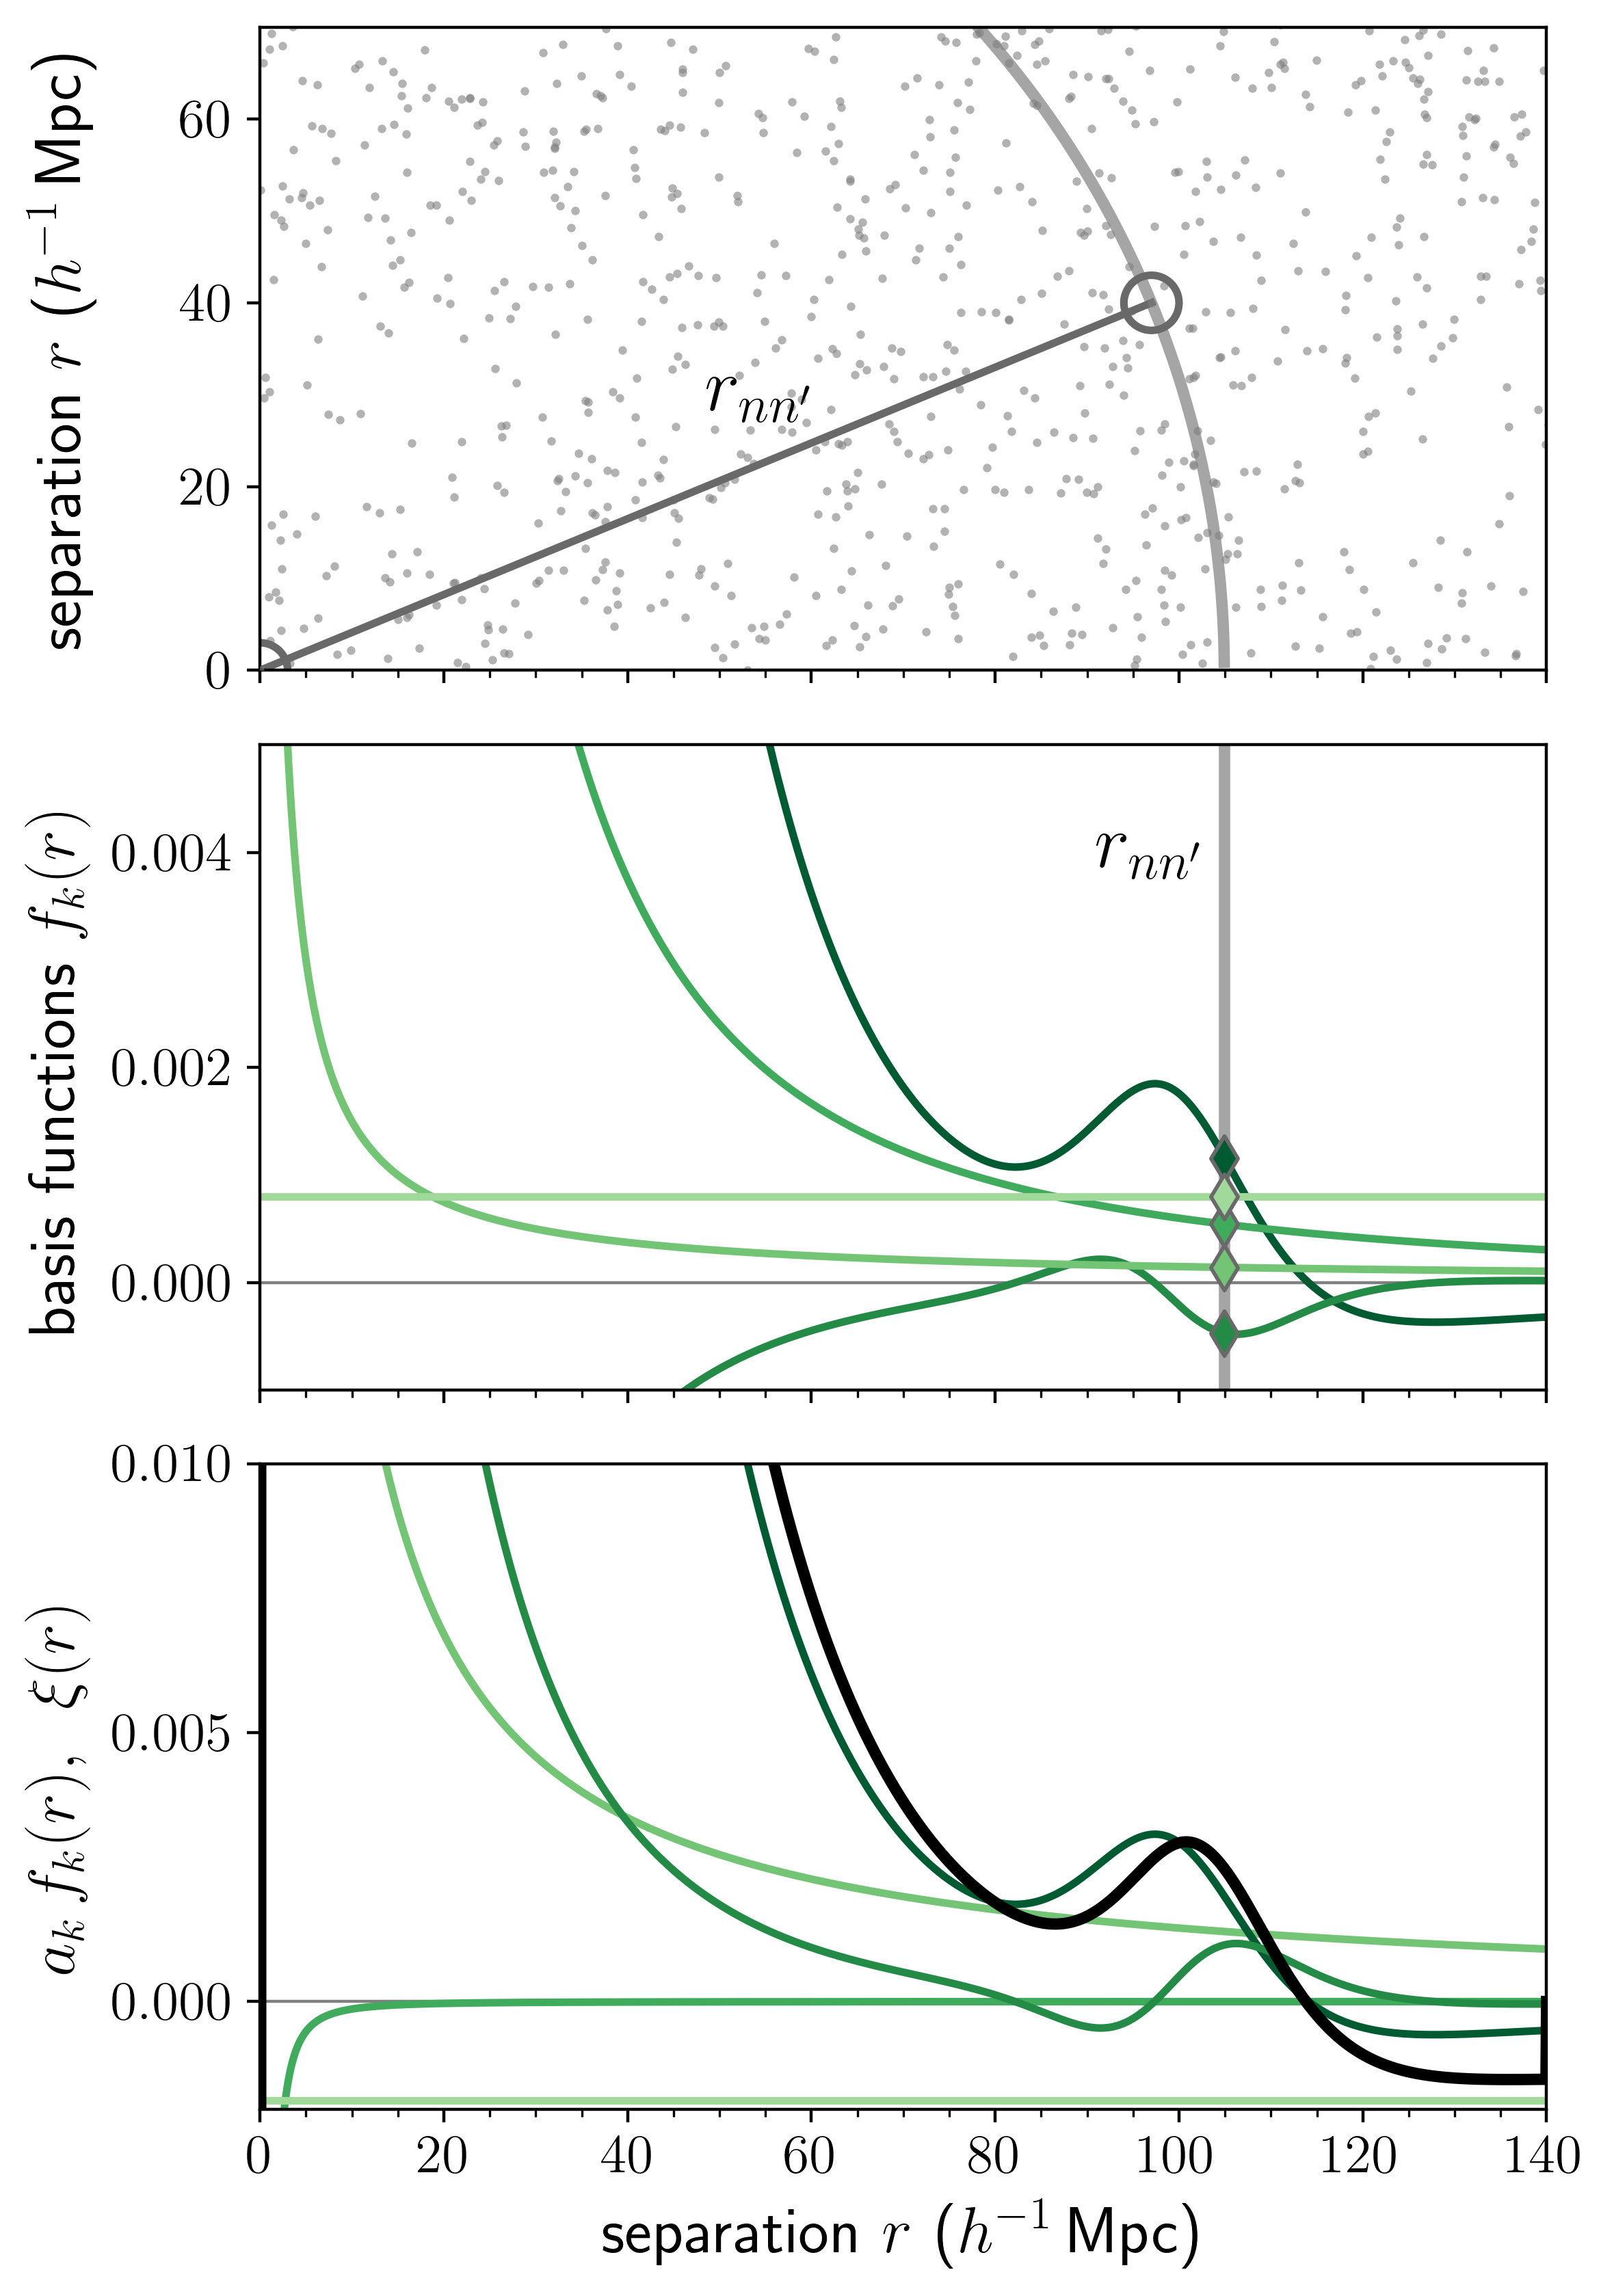

In [48]:
fig, axarr = plt.subplots(3,1, figsize=(6,8.5), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

# 1/r^2,1/r,const, model, deriv
rescale_by = [6, 0.15, 0.8, 1, 30]  
    
rsep, rcolor = data_panel(axarr[0], data, zslice=(0,400))
bases_panel(axarr[1], bases_bao, bao_base_colors, rsep, rcolor,
            bases_ordered=[3,4,0,1,2], rescale_by=rescale_by, ylim=(-0.001, 0.005))
results_panel(axarr[2], bases_bao, bao_base_colors, amps_ana_bao, r_fine, xi_ana_bao, ylim=(-0.002, 0.01))
fig.align_ylabels(axarr)

save_fn = 'schematic_bao.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 

# tophat basis

In [14]:
nprojbins_tophat = 16
r_edges_tophat = np.linspace(rmin, rmax, nprojbins_tophat+1)
projfn_tophat = None
#proj_type_tophat = 'tophat'
# we will use a zero order spline for the tophat to get the basis functions displayed more easily
proj_type_tophat = 'generalr'
kwargs_tophat = {'order': 0} # 3: cubic spline
projfn_tophat = '../tables/zero_spline.dat'
spline.write_bases(rmin, rmax, nprojbins_tophat, projfn_tophat, ncont=ncont, **kwargs_tophat)

'../tables/zero_spline.dat'

In [15]:
dd_res_tophat, dd_proj_tophat, _ = DDsmu(1, nthreads, r_edges_tophat, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type_tophat, 
                           nprojbins=nprojbins_tophat, projfn=projfn_tophat)

In [16]:
rr_ana_tophat, qq_ana_tophat = qq_analytic(rmin, rmax, nd, volume, nprojbins_tophat, proj_type_tophat, 
                                           projfn=projfn_tophat, rbins=r_edges_tophat)
numerator_tophat = dd_proj_tophat - rr_ana_tophat
amps_ana_tophat = np.linalg.solve(qq_ana_tophat, numerator_tophat)
xi_ana_tophat = evaluate_xi(amps_ana_tophat, r_fine, proj_type_tophat, projfn=projfn_tophat, rbins=r_edges_tophat)

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


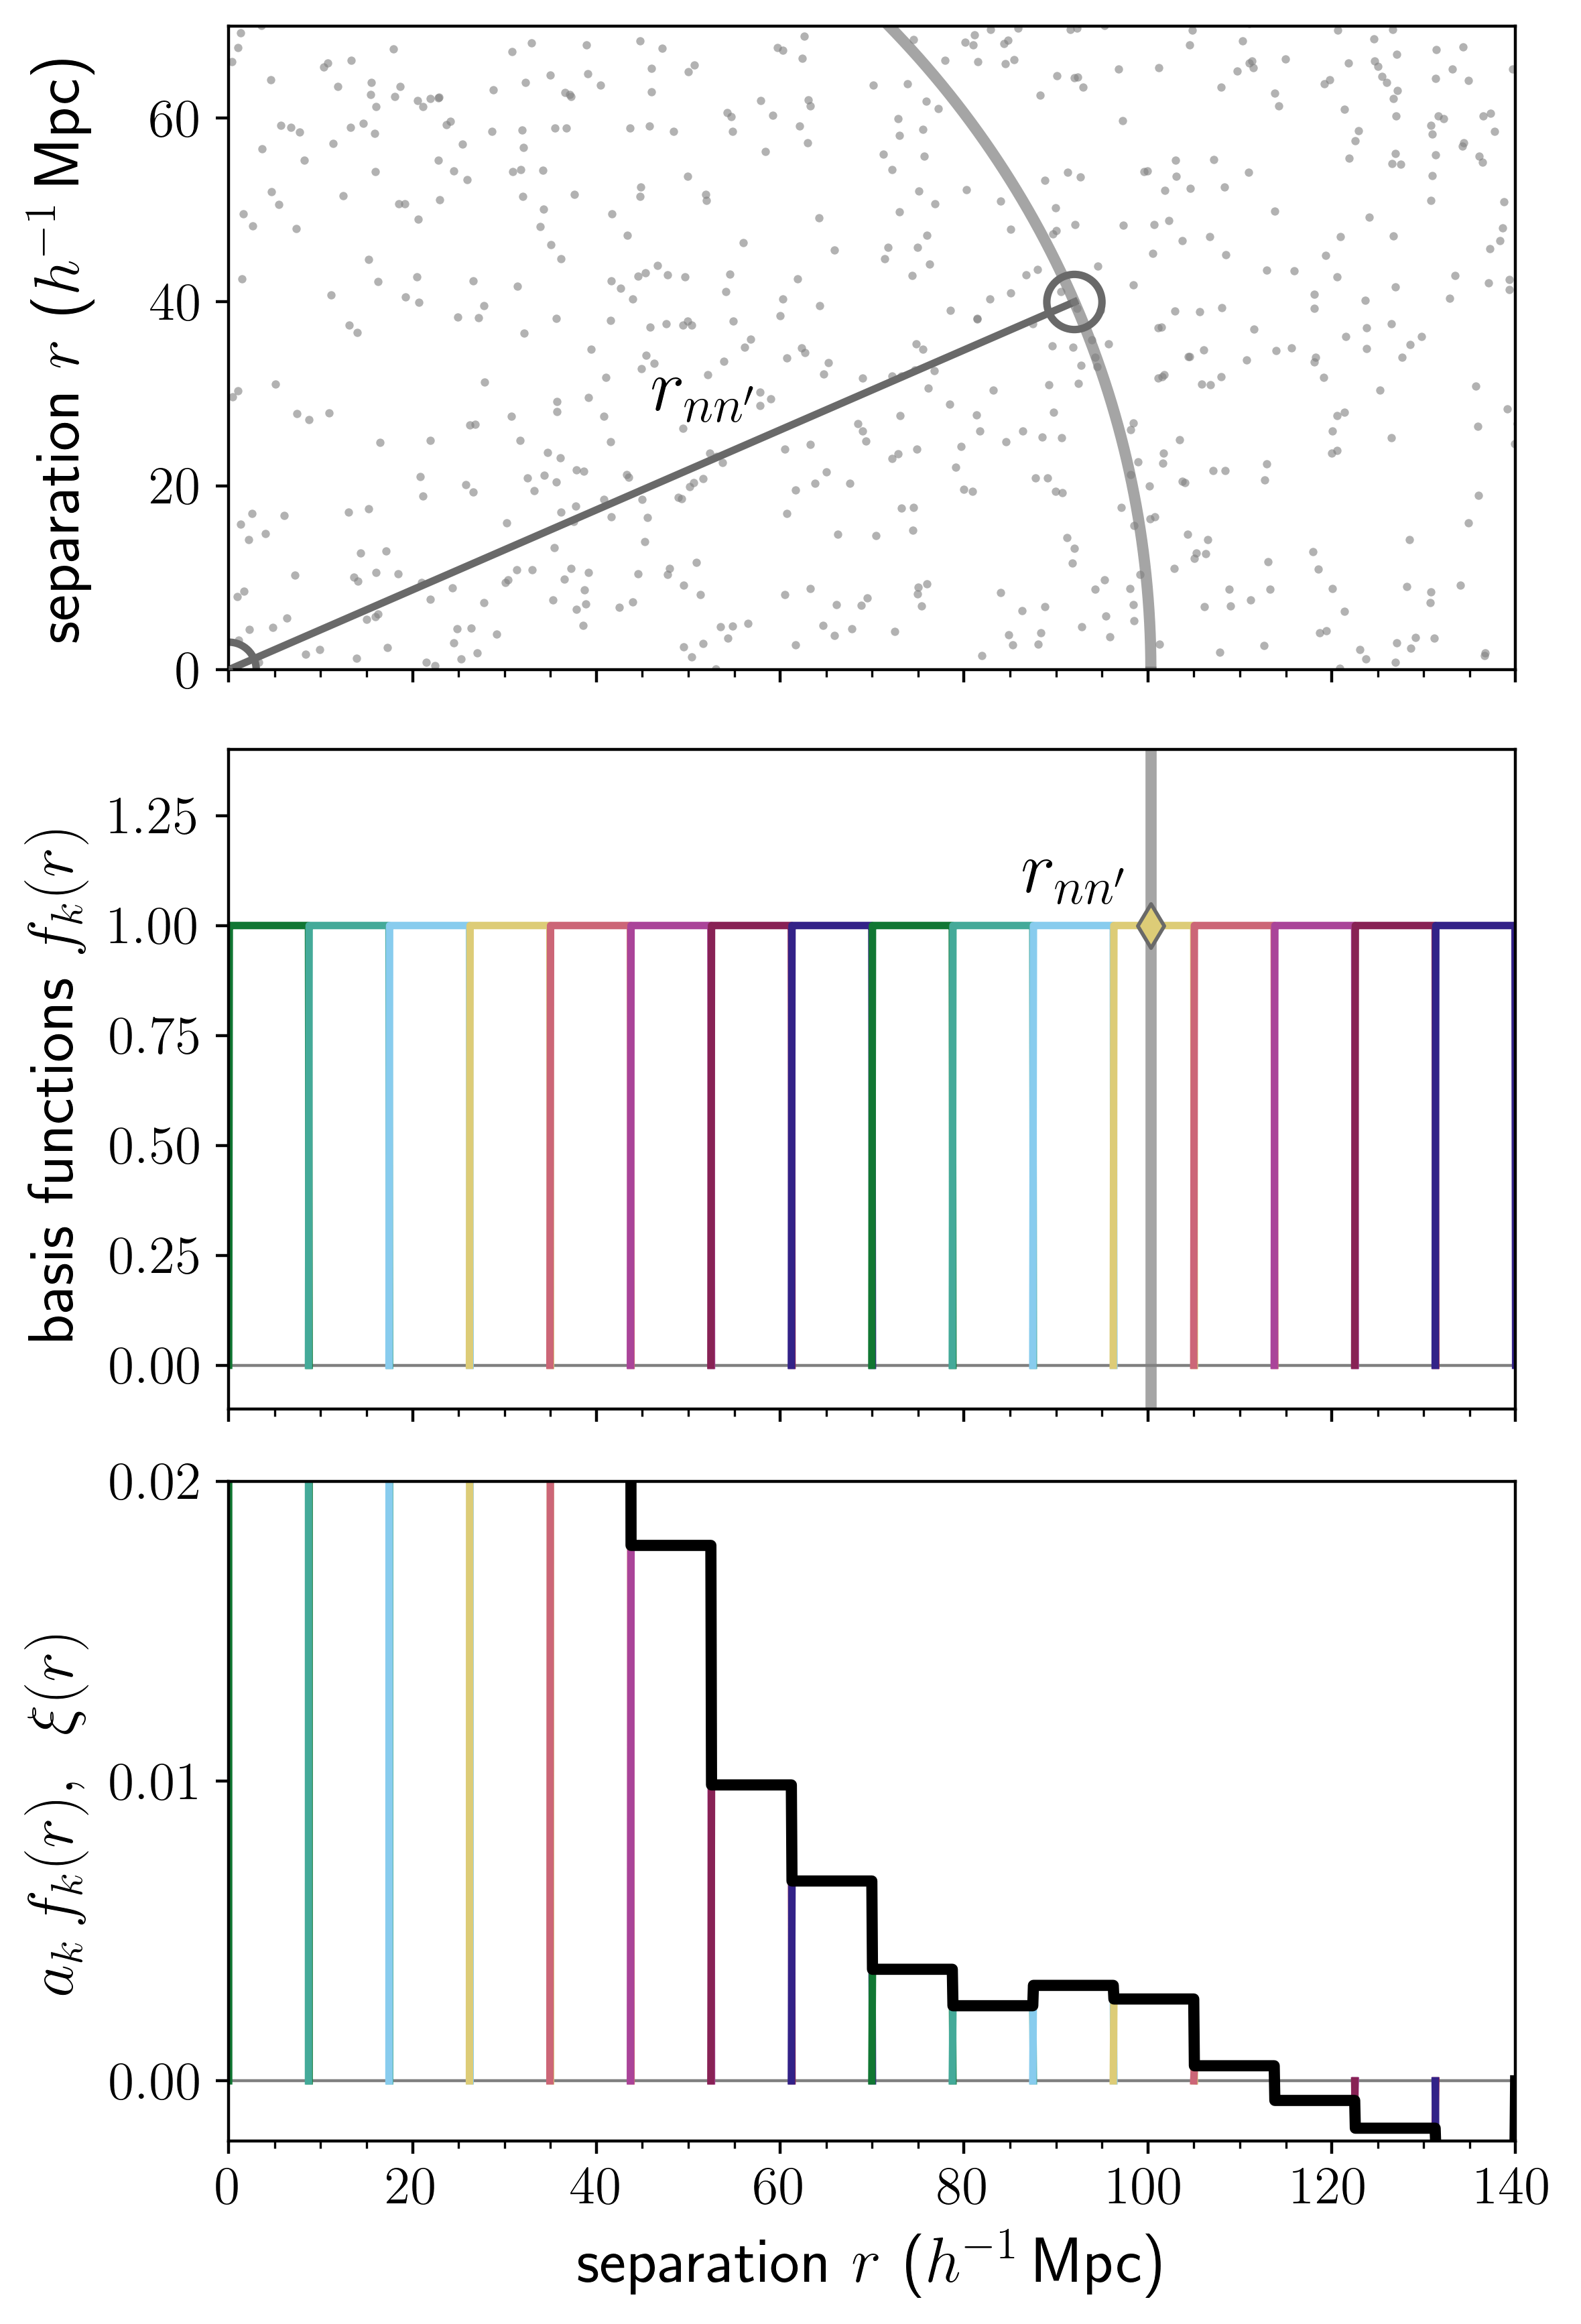

In [56]:
fig, axarr = plt.subplots(3,1, figsize=(6,8.8), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

bases_tophat = np.loadtxt(projfn_tophat)

rsep, rcolor = data_panel(axarr[0], data, gal=[92,40])
bases_panel(axarr[1], bases_tophat, colors, rsep, rcolor, ylim=(-0.1, 1.4))
results_panel(axarr[2], bases_tophat, colors, amps_ana_tophat, r_fine, xi_ana_tophat, ylim=(-0.002, 0.02))
fig.align_ylabels(axarr)

save_fn = 'schematic_tophat.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


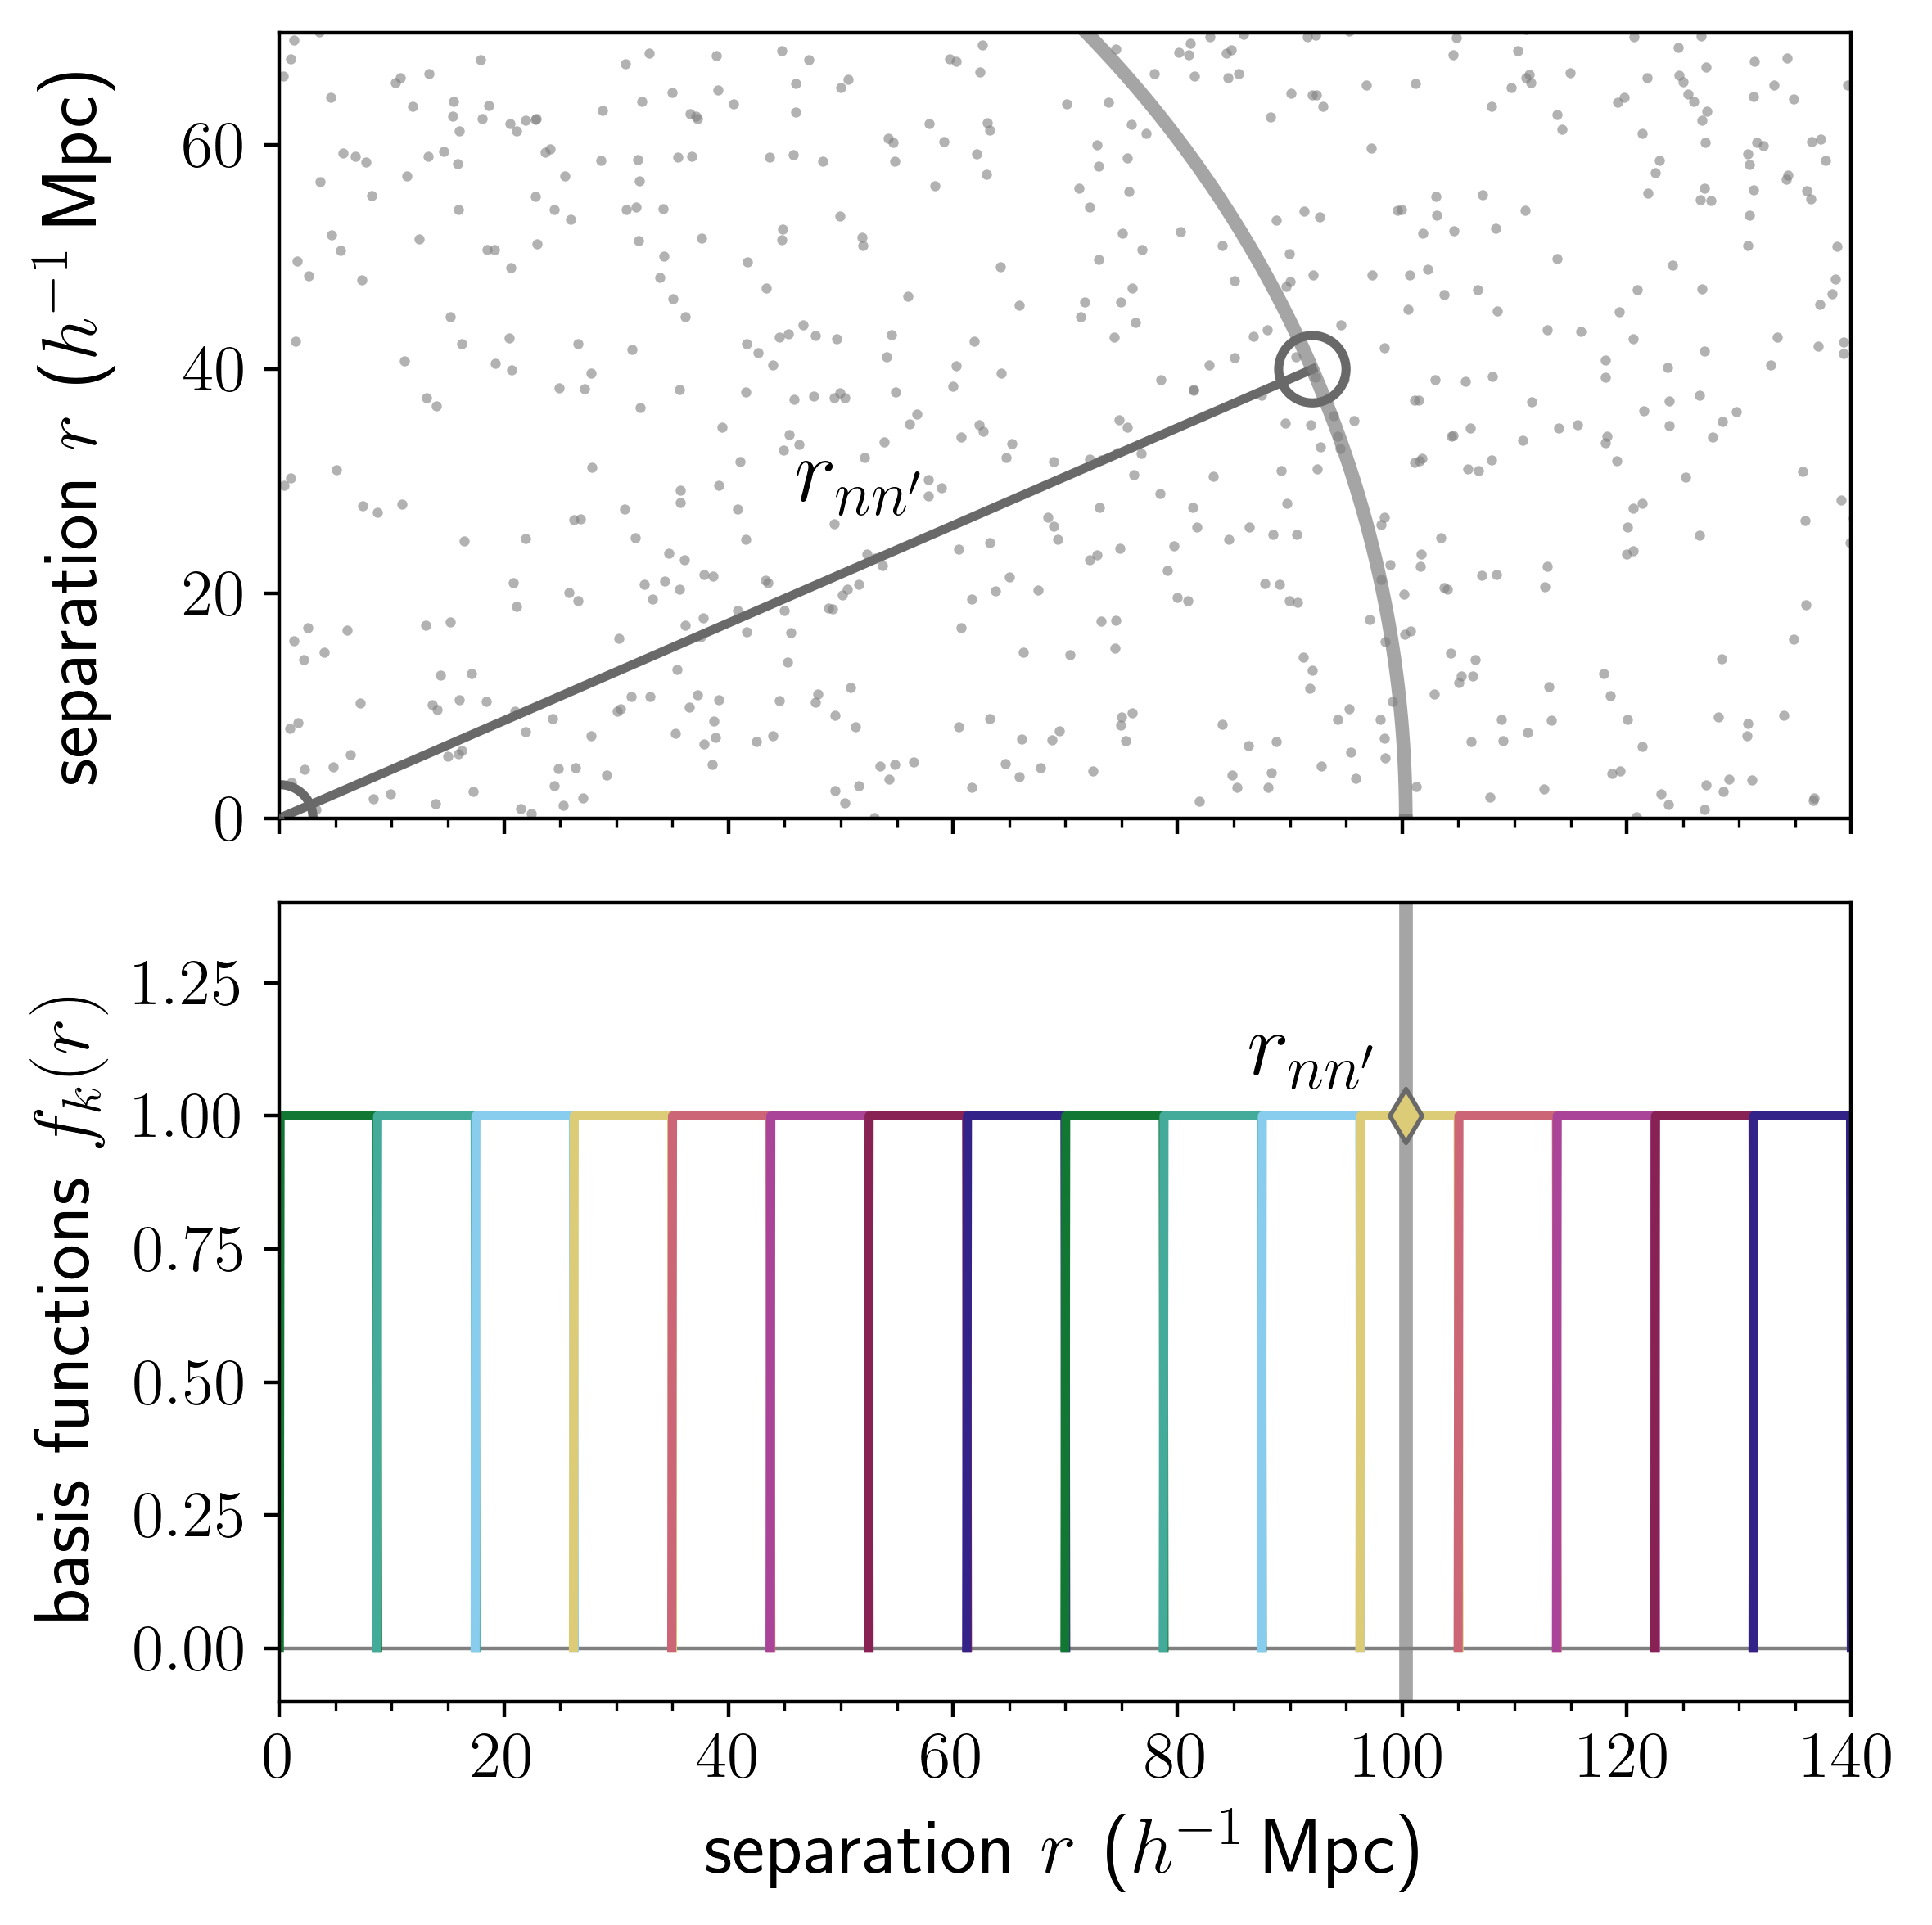

In [71]:
fig, axarr = plt.subplots(2,1, figsize=(6,2./3.*9.0), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

bases_tophat = np.loadtxt(projfn_tophat)

rsep, rcolor = data_panel(axarr[0], data, gal=[92,40])
bases_panel(axarr[1], bases_tophat, colors, rsep, rcolor, ylim=(-0.1, 1.4), labelx=True)
#results_panel(axarr[2], bases_tophat, colors, amps_ana_tophat, r_fine, xi_ana_tophat, ylim=(-0.002, 0.02))
fig.align_ylabels(axarr)

save_fn = 'schematic_tophat_2panel.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 

# occupation number

In [120]:
def occupation_number_panel(ax, data, zslice=(0,300), xlim=(0, 40), ylim=(0,20)):
    
    # settings
    marker = 'o'
    size=12
    col_points = 'grey'
    alpha_points = 0.6

    #cells
    cellsize = 1
    xlines = np.arange(*xlim, cellsize)
    ylines = np.arange(*ylim, cellsize)
    for xl in xlines:
        ax.axvline(xl, lw=0.2, color='k')
    for yl in ylines:
        ax.axhline(yl, lw=0.2, color='k')
        
    # all points
    in_slice = np.argwhere((zslice[0] <= data[2]) & (data[2] < zslice[1]))
    xdata = data[0][in_slice]
    ydata = data[1][in_slice]
    ax.scatter(xdata, ydata, marker=marker, c=col_points, s=size, alpha=alpha_points, lw=0)

    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set(xlim=xlim, ylim=ylim, aspect=1)
    ax.set(adjustable="box")
    

    
    return

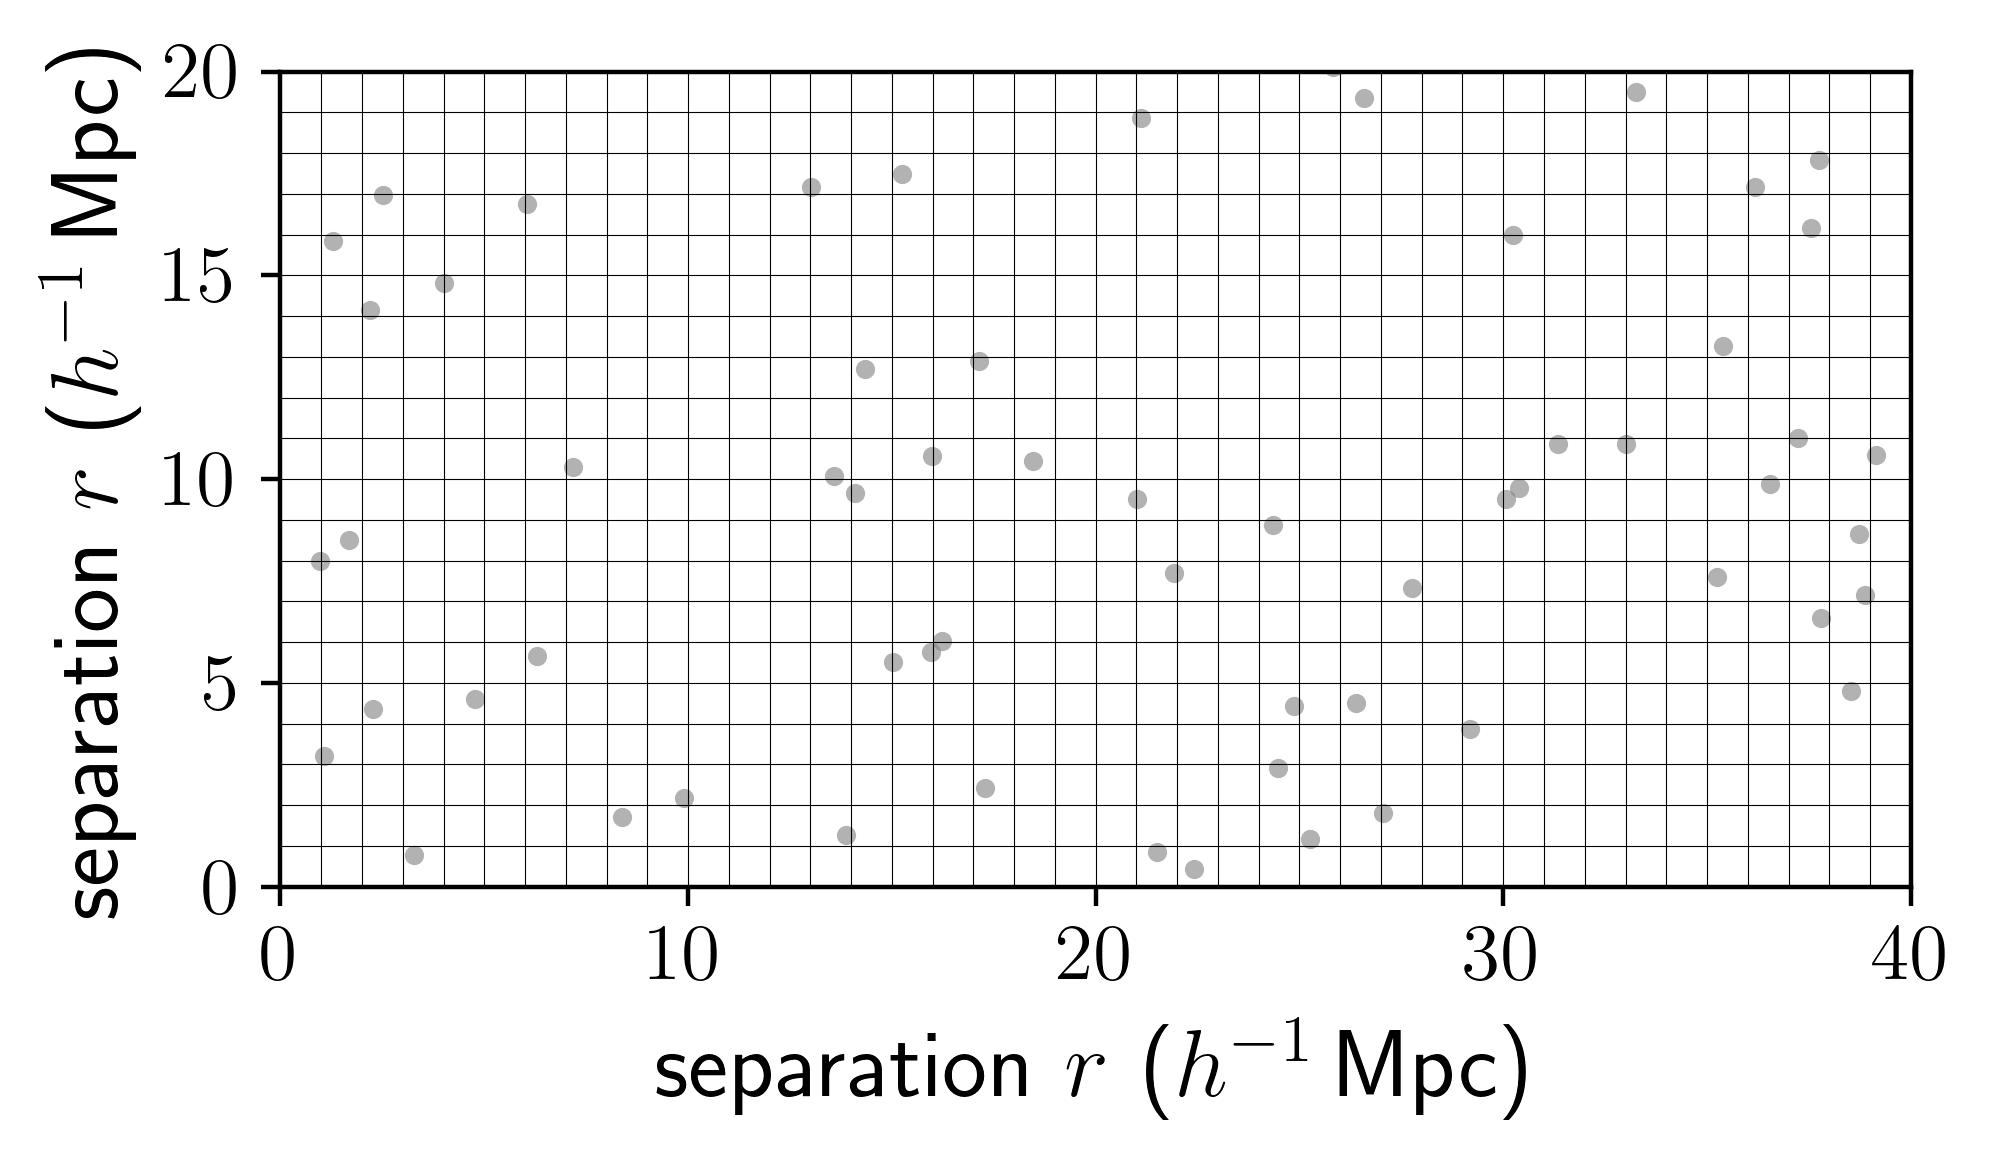

In [121]:
fig, ax = plt.subplots(1,1, figsize=(6,1./3.*9.0), sharex=True, gridspec_kw={'height_ratios': [1]})
plt.subplots_adjust(wspace=0.1, hspace=0.15)

bases_spline = np.loadtxt(projfn_spline)

occupation_number_panel(ax, data)
#bases_panel(axarr[1], bases_spline, colors, rsep, rcolor, ylim=(-0.1, 1), labelx=True)
#results_panel(axarr[2], bases_spline, colors, amps_ana_tophat, r_fine, xi_ana_tophat, ylim=(-0.002, 0.02))
#fig.align_ylabels(axarr)

save_fn = 'data_occupation_number.png'
#for some reason bbox_inches='tight' doesn't work, need this instead!
plt.tight_layout()
plt.savefig(f'{plot_dir}/{save_fn}')#, bbox_inches='tight') 